In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange
import warnings

In [2]:
file_users = '/Users/bradley.webb/Downloads/turn_board_user_visits.csv'
file_pmf_survey_response = '/Users/bradley.webb/Downloads/PollResponseList-csv-rId-af3889a9-4135-420d-bd31-c0bf06a53bef.csv'

In [95]:
df = pd.read_csv(file_users)
df2 = pd.read_csv(file_pmf_survey_response)

In [4]:
df2.columns

Index(['Visitor ID', 'Date', 'Response', 'email', 'Account ID', 'name',
       'UUID'],
      dtype='object')

In [7]:
df2.drop('UUID', axis=1, inplace=True)

In [9]:
df.columns

Index(['RECORDED_DAY', 'VHOST', 'USER_ID', 'UUID', 'PAGE_NAME', 'PAGE_VISITS',
       'TOTAL_TIME_SPENT_MINUTES', 'AVG_TIME_SPENT_PER_PAGE_VISIT_MINUTES'],
      dtype='object')

In [96]:
df['date'] = pd.to_datetime(df['RECORDED_DAY'])
df['user'] = df['UUID']

In [10]:
df2['Visitor ID'].unique().shape

(157,)

In [13]:
df3 = df.join(df2.set_index('Visitor ID'), on='UUID', rsuffix='_PMF')

In [33]:
x = df3[
    (df3['Account ID'].notnull() == True) &
    (df3.AVG_TIME_SPENT_PER_PAGE_VISIT_MINUTES > 1)
]['UUID']

In [39]:
df2[df2['Visitor ID'].isin(x)].groupby('Response').count()

,Visitor ID,Date,email,Account ID,name
Response,,,,,
Not disappointed,19,19,19,19,19
Somewhat disappointed,14,14,14,14,14
Very disappointed,40,40,40,40,40


In [58]:
x = df[
    (df.AVG_TIME_SPENT_PER_PAGE_VISIT_MINUTES > 1)   
][['date','TOTAL_TIME_SPENT_MINUTES']].groupby('date').sum().reset_index()['date']

y = df[
    (df.AVG_TIME_SPENT_PER_PAGE_VISIT_MINUTES > 1)   
][['date','TOTAL_TIME_SPENT_MINUTES']].groupby('date').sum().reset_index()['TOTAL_TIME_SPENT_MINUTES']

In [69]:
y2 = y.rolling(30).mean()

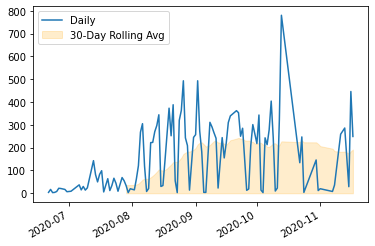

In [78]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.fill_between(x, y2, color='orange', alpha=.2)
fig.autofmt_xdate()
ax.legend(('Daily', '30-Day Rolling Avg'))
plt.show()

In [80]:
df[['UUID', 'date']]

,UUID,date
0,2e36641a-ff2a-11e9-827d-b083fed171ad,2020-06-21
1,2e36641a-ff2a-11e9-827d-b083fed171ad,2020-06-21
2,1f8dc358-5719-11ea-9c4e-02cfcd2eb442,2020-06-22
3,1f8dc358-5719-11ea-9c4e-02cfcd2eb442,2020-06-22
4,2397aef6-faa1-11e9-8430-1866da72a534,2020-06-22
...,...,...
6445,f20b3093-28cc-11ea-9625-028f2ae8fd40,2020-11-17
6446,2d4da312-2516-11eb-8f3b-062010a2d446,2020-11-17
6447,10e7a68e-1266-11eb-8abf-02fa3c15faa6,2020-11-17
6448,1a4c365e-accd-11ea-8f8b-0aec14e13d34,2020-11-17


In [81]:
def active_users_by_cohort(event_df, period_length):
    active_user_df = pd.DataFrame({"date": pd.date_range(event_df['date'].min(), event_df['date'].max())})
    active_user_count_df = pd.DataFrame({"date": pd.date_range(event_df['date'].min(), event_df['date'].max())})
    existing_users = set()
    for cohort_date in trange(len(active_user_df)):
        active_user_df[cohort_date] = np.nan
        active_user_count_df[cohort_date] = 0
        origin_date = active_user_df['date'][cohort_date]
        offset_date = origin_date - pd.offsets.Day(int(period_length))
        base_cohort = set(event_df[
                             (event_df['date'] <= origin_date) & 
                             (event_df['date'] > offset_date)  
                             ]['user'].unique()) - existing_users
        existing_users.update(base_cohort)
        for i in range(cohort_date, len(active_user_df)):
            origin_date = active_user_df['date'][i]
            offset_date = origin_date - pd.offsets.Day(int(period_length))
            current_cohort = set(event_df[
                             (event_df['date'] <= origin_date) & 
                             (event_df['date'] > offset_date)  
                             ]['user'].unique())
            if len(base_cohort) != 0:
                active_user_df.loc[i, cohort_date] = len(base_cohort & current_cohort)/len(base_cohort)
                active_user_count_df.loc[i, cohort_date] = len(base_cohort & current_cohort)
    return active_user_df, active_user_count_df

In [137]:
df_rate, df_count = active_users_by_cohort(df, 31)
df_d_rate, df_d_count = active_users_by_cohort(df, 1)

In [204]:
# df_d_count.loc[:, df_d_count.columns != 'date']/df_count.loc[:, df_count.columns != 'date']
np.diag(df_count.iloc[:,1:])

array([ 1,  5,  5,  4,  2,  4,  0,  0,  3,  5,  2,  2,  1,  1,  1,  3,  1,
        3,  3,  2,  0,  0,  5,  4,  4,  8,  9,  0,  0,  4,  1,  2,  3,  6,
        1,  1,  0,  1,  2,  1,  5,  0,  0,  4, 69, 76, 58, 61,  5,  8, 57,
       37, 53, 41, 32,  9,  3, 30, 42, 46, 37, 45,  5,  3, 35, 45, 34, 31,
       31,  4,  0, 19, 28, 34, 27, 18,  2,  2,  4, 38, 23, 29, 26,  4,  1,
       30, 26, 28, 31, 18,  2,  3, 36, 26, 35, 36, 23,  3,  4, 15, 24, 25,
       27, 14,  4,  1, 27, 34, 36, 19, 20,  2,  2, 28, 15,  0,  0,  0,  0,
        1,  0,  0,  0, 29, 21,  2,  3,  0,  0,  0,  0, 20,  2,  5,  0,  0,
        0,  0,  0,  3,  5,  0,  0, 21,  0, 36,  0,  1, 25, 32])

In [89]:
def cohort_mean(df_counts, df_rates):
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='invalid value encountered in true_divide')
        cohort_mean = dict()
        usage_rate_by_day = {i*-1: np.diag(df_rates.iloc[:, df_rates.columns != 'date'], i).astype('float64') for i in range(-1*(df_rates.shape[0]-1), 1)}
        users_by_cohort_day = {i*-1: np.diag(df_counts.iloc[:, df_counts.columns != 'date'], i).astype('float64') for i in range(-1*(df_counts.shape[0]-1), 1)}
        for key, val in users_by_cohort_day.items():
            cohort_mean[key] = users_by_cohort_day[key].sum() / np.nansum(users_by_cohort_day[key] / usage_rate_by_day[key])
    return cohort_mean

In [157]:
user_counts = {'MAU': [df_count, df_rate], 'DAU': [df_d_count, df_d_rate]}
max_dim = max([v[0].shape[0] for v in user_counts.values()])

df_cohort = pd.DataFrame(index=range(max_dim))
for cohort, data in user_counts.items():
    df_cohort[cohort] = np.nan
    computed_mean = cohort_mean(data[0], data[1])
    for key, val in computed_mean.items():
        df_cohort.loc[key, cohort] = val

<ipython-input-89-ee5597c05946>:8: RuntimeWarning: invalid value encountered in double_scalars
  cohort_mean[key] = users_by_cohort_day[key].sum() / np.nansum(users_by_cohort_day[key] / usage_rate_by_day[key])


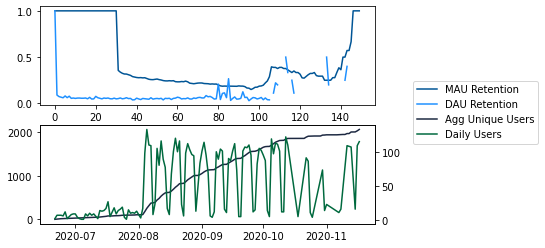

In [252]:
fig, (ax1, ax2) = plt.subplots(2,1)

data_1 = ax1.plot(df_cohort.index, df_cohort['MAU'], label='MAU Retention', color='#005596')
data_2 = ax1.plot(df_cohort.index, df_cohort['DAU'], label='DAU Retention', color='#1E90FF')

data_3 = ax2.plot(df_count.date , np.diag(df_count.iloc[:, 1:]).cumsum(), label='Agg Unique Users', color='#1C2841')
ax3 = ax2.twinx()
data_4 = ax3.plot(df['date'].unique(), df.groupby(['date']).agg(['count'])['user'], label='Daily Users', color='#00693E')

plt.legend(handles=[data_1[0], data_2[0], data_3[0], data_4[0]], bbox_to_anchor=(1.1, 1.5), loc='upper left')

plt.show()